# Description

This course is free of cost on Kaggle and anyone can do it to brush up their data cleaning skills.

It consists of five chapters with exercises:-
1. Handling Missing Values
2. Scaling and Normalization
3. Parsing Dates
4. Character Encodings
5. Inconsistent Data Entry¶

## <font color=navy>[1/5] Handling Missing Values</font>

Welcome to the Data Cleaning course on Kaggle Learn!

Data cleaning is a key part of data science, but it can be deeply frustrating. Why are some of your text fields garbled? What should you do about those missing values? Why aren’t your dates formatted correctly? How can you quickly clean up inconsistent data entry? In this course, you'll learn why you've run into these problems and, more importantly, how to fix them!

In this course, you’ll learn how to tackle some of the most common data cleaning problems so you can get to actually analyzing your data faster. You’ll work through five hands-on exercises with real, messy data and answer some of your most commonly-asked data cleaning questions.

In this notebook, we'll look at how to deal with missing values.

### Take a first look at the data
The first thing we'll need to do is load in the libraries and dataset we'll be using.

For demonstration, we'll use a dataset of events that occured in American Football games.  
In the following exercise, you'll apply your new skills to a dataset of building permits issued in San Francisco.



In [43]:
import pandas as pd
import numpy as np

# read in all our data
nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")

# set seed for reproducibility
np.random.seed(0) 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (25,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


The first thing to do when you get a new dataset is take a look at some of it. This lets you see that it all read in correctly and gives an idea of what's going on with the data. In this case, let's see if there are any missing values, which will be reprsented with NaN or None.

In [44]:
# look at the first five rows of the nfl_data file. 
# I can see a handful of missing data already!
nfl_data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


Yep, it looks like there's some missing values.

### How many missing data points do we have?

Ok, now we know that we do have some missing values. Let's see how many we have in each column.

In [45]:
# get the number of missing data points per column
missing_values_count = nfl_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

That seems like a lot! It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [46]:
# how many total missing values do we have?
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

24.87214126835169


Wow, almost a quarter of the cells in this dataset are empty! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

### Figure out why the data is missing

This is the point at which we get into the part of data science that I like to call "data intution", by which I mean "really looking at your data and trying to figure out why it is the way it is and how that will affect your analysis". It can be a frustrating part of data science, especially if you're newer to the field and don't have a lot of experience. For dealing with missing values, you'll need to use your intution to figure out why the value is missing. One of the most important questions you can ask yourself to help figure this out is this:

> Is this value missing because it wasn't recorded or because it doesn't exist?

If a value is missing becuase it doesn't exist (like the height of the oldest child of someone who doesn't have any children) then it doesn't make sense to try and guess what it might be. These values you probably do want to keep as NaN. On the other hand, if a value is missing because it wasn't recorded, then you can try to guess what it might have been based on the other values in that column and row. This is called **imputation**, and we'll learn how to do it next! :)

Let's work through an example. Looking at the number of missing values in the nfl_data dataframe, I notice that the column "TimesSec" has a lot of missing values in it:

In [47]:
# look at the # of missing points in the first ten columns
missing_values_count[0:10]

Date                0
GameID              0
Drive               0
qtr                 0
down            61154
time              224
TimeUnder           0
TimeSecs          224
PlayTimeDiff      444
SideofField       528
dtype: int64

By looking at the [documentation](https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016), I can see that this column has information on the number of seconds left in the game when the play was made. This means that these values are probably missing because they were not recorded, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's.

On the other hand, there are other fields, like "PenalizedTeam" that also have lot of missing fields. In this case, though, the field is missing because if there was no penalty then it doesn't make sense to say which team was penalized. For this column, it would make more sense to either leave it empty or to add a third value like "neither" and use that to replace the NA's.

> **Tip**: This is a great place to read over the dataset documentation if you haven't already! If you're working with a dataset that you've gotten from another person, you can also try reaching out to them to get more information.

If you're doing very careful data analysis, this is the point at which you'd look at each column individually to figure out the best strategy for filling those missing values. For the rest of this notebook, we'll cover some "quick and dirty" techniques that can help you with missing values but will probably also end up removing some useful information or adding some noise to your data.

### Drop missing values
If you're in a hurry or don't have a reason to figure out why your values are missing, one option you have is to just remove any rows or columns that contain missing values. (Note: I don't generally recommend this approch for important projects! It's usually worth it to take the time to go through your data and really look at all the columns with missing values one-by-one to really get to know your dataset.)

If you're sure you want to drop rows with missing values, pandas does have a handy function, dropna() to help you do this. Let's try it out on our NFL dataset!

In [48]:
# remove all the rows that contain a missing value
nfl_data.dropna()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


Oh dear, it looks like that's removed all our data! 😱 This is because every row in our dataset had at least one missing value. We might have better luck removing all the columns that have at least one missing value instead.

In [49]:
# remove all columns with at least one missing value
columns_with_na_dropped = nfl_data.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,Timeout_Indicator,Timeout_Team,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,0,None,3,3,3,3,3,0.0,0.0,2009


In [50]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % nfl_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 102 

Columns with na's dropped: 41


We've lost quite a bit of data, but at this point we have successfully removed all the NaN's from our data.

### Filling in missing values automatically

Another option is to try and fill in the missing values. For this next bit, I'm getting a small sub-section of the NFL data so that it will print well.

In [51]:
# get a small subset of the NFL dataset
subset_nfl_data = nfl_data.loc[:, 'EPA':'Season'].head()
subset_nfl_data

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,NaN,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,NaN,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,NaN,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009


We can use the Panda's `fillna()` function to fill in missing values in a dataframe for us. One option we have is to specify what we want the `NaN` values to be replaced with. Here, I'm saying that I would like to replace all the `NaN` values with 0.

In [52]:
# replace all NA's with 0
subset_nfl_data.fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,0.000000,0.000000,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,0.000000,0.000000,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,0.000000,0.000000,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.000000,0.000000,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


I could also be a bit more savvy and replace missing values with whatever value comes directly after it in the same column. (This makes a lot of sense for datasets where the observations have some sort of logical order to them.)

In [53]:
# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

,EPA,airEPA,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2.014474,-1.068169,1.146076,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,-0.032244,0.036899,2009
1,0.077907,-1.068169,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,-1.402760,3.318841,-5.031425,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,0.106663,-0.156239,2009
3,-1.712583,3.318841,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2.097796,0.000000,0.000000,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,0.000000,0.000000,2009


### Exercises (Chapter-1)

### 1) Take a first look at the data
Run the next code cell to load in the libraries and dataset you'll use to complete the exercise.

In [54]:
# modules we'll use
import pandas as pd
import numpy as np

# read in all our data
sf_permits = pd.read_csv("Building_Permits.csv")

# set seed for reproducibility
np.random.seed(0) 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Use the code cell below to print the first five rows of the sf_permits DataFrame.

In [55]:
sf_permits.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


Does the dataset have any missing value?

The first five rows of the data does show that several columns have missing values. You can see this in the "Street Number Suffix", "Proposed Construction Type" and "Site Permit" columns, among others.

### 2) How many missing data points do we have?

What percentage of the values in the dataset are missing?  Your answer should be a number between 0 and 100.  (If 1/4 of the values in the dataset are missing, the answer is 25.)

In [56]:
percent_missing = 100 * ((sf_permits.isnull().sum().sum())/(np.product(sf_permits.shape)))
percent_missing

26.26002315058403

### 3) Figure out why the data is missing

Look at the columns **"Street Number Suffix"** and **"Zipcode"** from the [San Francisco Building Permits dataset](https://www.kaggle.com/aparnashastry/building-permit-applications-data). Both of these contain missing values. 
- Which, if either, are missing because they don't exist? 
- Which, if either, are missing because they weren't recorded?  

Once you have an answer, run the code cell below.

In [57]:
sf_permits['Street Number Suffix'].isnull().sum()

196684

In [58]:
sf_permits['Zipcode'].isnull().sum()

1716

If a value in the "Street Number Suffix" column is missing, it is likely because it does not exist. If a value in the "Zipcode" column is missing, it was not recorded.




### 4) Drop missing values: rows

If you removed all of the rows of `sf_permits` with missing values, how many rows are left?

**Note**: Do not change the value of `sf_permits` when checking this.  

In [59]:
sf_permits.dropna()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID


There are no rows remaining in the dataset!

### 5) Drop missing values: columns

Now try removing all the columns with empty values.  
- Create a new DataFrame called `sf_permits_with_na_dropped` that has all of the columns with empty values removed.  
- How many columns were removed from the original `sf_permits` DataFrame? Use this number to set the value of the `dropped_columns` variable below.

In [60]:
sf_permits_with_na_dropped = sf_permits.dropna(axis=1)

dropped_columns = sf_permits.shape[1] - sf_permits_with_na_dropped.shape[1]
dropped_columns

31

### 6) Fill in missing values automatically

Try replacing all the NaN's in the `sf_permits` data with the one that comes directly after it and then replacing any remaining NaN's with 0.  Set the result to a new DataFrame `sf_permits_with_na_imputed`.

In [61]:
sf_permits_with_na_imputed = sf_permits.fillna(method='bfill', axis=0).fillna(0)

In [62]:
sf_permits_with_na_imputed

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,A,Ellis,St,...,3.0,constr type 3,1.0,constr type 1,Y,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,A,Geary,St,...,3.0,constr type 3,1.0,constr type 1,Y,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,A,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,Y,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,A,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),Y,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,A,Market,St,...,3.0,constr type 3,1.0,constr type 1,Y,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198895,M862628,8,otc alterations permit,12/05/2017,0113,017A,1228,0,Montgomery,St,...,5.0,wood frame (5),5.0,wood frame (5),0,0.0,0,0.0,0,1489337276729
198896,201712055595,8,otc alterations permit,12/05/2017,0271,014,580,0,Bush,St,...,5.0,wood frame (5),5.0,wood frame (5),0,0.0,0,0.0,0,1489462354993
198897,M863507,8,otc alterations permit,12/06/2017,4318,019,1568,0,Indiana,St,...,0.0,0,0.0,0,0,0.0,0,0.0,0,1489539379952
198898,M863747,8,otc alterations permit,12/06/2017,0298,029,795,0,Sutter,St,...,0.0,0,0.0,0,0,0.0,0,0.0,0,1489608233656


## <font color=navy>[2/5] Scaling and Normalization</font>

In this notebook, we're going to be looking at how to scale and normalize data (and what the difference is between the two!).

Let's get started!

### Get our environment set up

The first thing we'll need to do is load in the libraries we'll be using.

In [63]:
# modules we'll use
import pandas as pd
import numpy as np

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# set seed for reproducibility
np.random.seed(0)

### Scaling vs. Normalization: What's the difference?  

One of the reasons that it's easy to get confused between scaling and normalization is because the terms are sometimes used interchangeably and, to make it even more confusing, they are very similar! In both cases, you're transforming the values of numeric variables so that the transformed data points have specific helpful properties. The difference is that:

**In scaling, you're changing the range of your data, while
in normalization, you're changing the shape of the distribution of your data.**  

Let's talk a little more in-depth about each of these options.

#### Scaling
This means that you're **transforming your data so that it fits within a specific scale, like 0-100 or 0-1**. You want to scale data when you're using methods based on measures of how far apart data points are, like ***support vector machines (SVM)*** or ***k-nearest neighbors (KNN)***. With these algorithms, a change of "1" in any numeric feature is given the same importance.

For example, you might be looking at the prices of some products in both Yen and US Dollars. One US Dollar is worth about 100 Yen, but if you don't scale your prices, methods like SVM or KNN will consider a difference in price of 1 Yen as important as a difference of 1 US Dollar! This clearly doesn't fit with our intuitions of the world. With currency, you can convert between currencies. But what about if you're looking at something like height and weight? It's not entirely clear how many pounds should equal one inch (or how many kilograms should equal one meter).

**By scaling your variables, you can help compare different variables on equal footing.**  

To help solidify what scaling looks like, let's look at a made-up example. 

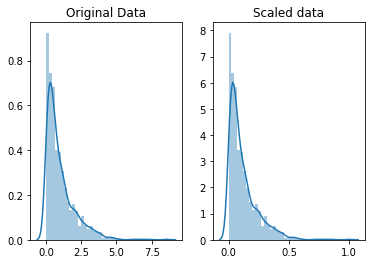

In [64]:
# generate 1000 data points randomly drawn from an exponential distribution
original_data = np.random.exponential(size=1000)

# min-max scale the data between 0 and 1
scaled_data = minmax_scaling(original_data, columns=[0])

# plot both together to compare
fig, ax = plt.subplots(1,2)
sns.distplot(original_data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

plt.show()

Notice that the shape of the data doesn't change, but that instead of ranging from 0 to 8ish, it now ranges from 0 to 1.

### Normalization  

Scaling just changes the range of your data. Normalization is a more radical transformation.   
**The point of normalization is to change your observations so that they can be described as a normal distribution.**

> **Normal distribution**: Also known as the "**bell curve**", this is a specific statistical distribution where a roughly equal observations fall above and below the mean, the mean and the median are the same, and there are more observations closer to the mean. The normal distribution is also known as the **Gaussian distribution.**

In general, you'll normalize your data if you're going to be using a machine learning or statistics technique that assumes your data is normally distributed. Some examples of these include **linear discriminant analysis (LDA)** and **Gaussian naive Bayes**. 

`(Pro tip: any method with "Gaussian" in the name probably assumes normality.)`

The method we're using to normalize here is called the [Box-Cox Transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation).  
Let's take a quick peek at what normalizing some data looks like:

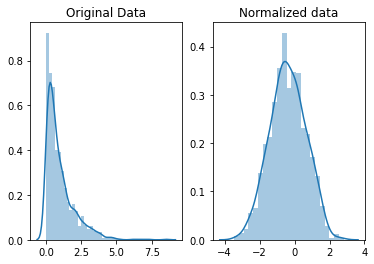

In [65]:
# normalize the exponential data with boxcox
normalized_data = stats.boxcox(original_data)

# plot both together to compare
fig, ax=plt.subplots(1,2)

sns.distplot(original_data, ax=ax[0])
ax[0].set_title("Original Data")

sns.distplot(normalized_data[0], ax=ax[1])
ax[1].set_title("Normalized data")

plt.show()

Notice that the shape of our data has changed. Before normalizing it was almost L-shaped. But after normalizing it looks more like the outline of a bell (hence "bell curve").

### Exercises (Chapter-2)

### Get our environment set up
To practice scaling and normalization, we're going to use a [dataset of Kickstarter campaigns](https://www.kaggle.com/kemical/kickstarter-projects). (Kickstarter is a website where people can ask people to invest in various projects and concept products.)

The next code cell loads in the libraries and dataset we'll be using.

In [67]:
# modules we'll use
import pandas as pd
import numpy as np

# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# read in all our data
kickstarters_2017 = pd.read_csv("ks-projects-201801.csv")

# set seed for reproducibility
np.random.seed(0)

Let's start by scaling the goals of each campaign, which is how much money they were asking for. The plots show a histogram of the values in the "usd_goal_real" column, both before and after scaling.

Text(0.5, 1.0, 'Scaled data')

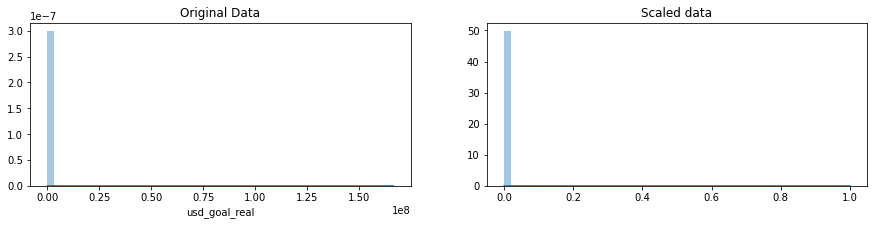

In [68]:
# select the usd_goal_real column
original_data = pd.DataFrame(kickstarters_2017.usd_goal_real)

# scale the goals from 0 to 1
scaled_data = minmax_scaling(original_data, columns=['usd_goal_real'])

# plot the original & scaled data together to compare
fig, ax=plt.subplots(1,2,figsize=(15,3))
sns.distplot(kickstarters_2017.usd_goal_real, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

After scaling, all values lie between 0 and 1 (you can read this in the horizontal axis of the second plot above, and we verify in the code cell below).

In [69]:
print('Original data\nPreview:\n', original_data.head())
print('Minimum value:', float(original_data.min()),
      '\nMaximum value:', float(original_data.max()))
print('_'*30)

print('\nScaled data\nPreview:\n', scaled_data.head())
print('Minimum value:', float(scaled_data.min()),
      '\nMaximum value:', float(scaled_data.max()))

Original data
Preview:
    usd_goal_real
0        1533.95
1       30000.00
2       45000.00
3        5000.00
4       19500.00
Minimum value: 0.01 
Maximum value: 166361390.71
______________________________

Scaled data
Preview:
    usd_goal_real
0       0.000009
1       0.000180
2       0.000270
3       0.000030
4       0.000117
Minimum value: 0.0 
Maximum value: 1.0


### 1) Practice scaling

We just scaled the "usd_goal_real" column. What about the "goal" column?

Begin by running the code cell below to create a DataFrame `original_goal_data` containing the "goal" column.

In [70]:
# select the usd_goal_real column
original_goal_data = pd.DataFrame(kickstarters_2017.goal)

Use original_goal_data to create a new DataFrame scaled_goal_data with values scaled between 0 and 1. You must use the minimax_scaling() function.

In [71]:
scaled_goal_data = minmax_scaling(original_goal_data, columns=['goal'])

### 2) Practice normalization
Now you'll practice normalization. We begin by normalizing the amount of money pledged to each campaign.

Text(0.5, 1.0, 'Normalized data')

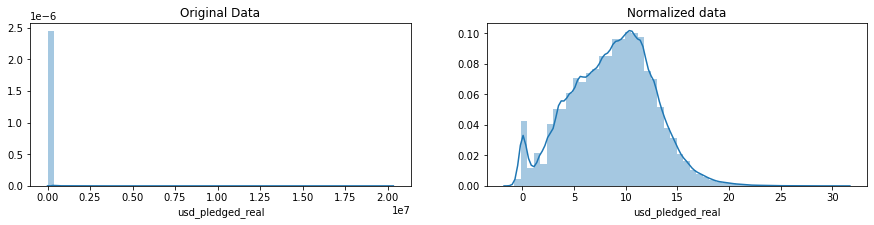

In [72]:
# get the index of all positive pledges (Box-Cox only takes positive values)
index_of_positive_pledges = kickstarters_2017.usd_pledged_real > 0

# get only positive pledges (using their indexes)
positive_pledges = kickstarters_2017.usd_pledged_real.loc[index_of_positive_pledges]

# normalize the pledges (w/ Box-Cox)
normalized_pledges = pd.Series(stats.boxcox(positive_pledges)[0], 
                               name='usd_pledged_real', index=positive_pledges.index)

# plot both together to compare
fig, ax=plt.subplots(1,2,figsize=(15,3))
sns.distplot(positive_pledges, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_pledges, ax=ax[1])
ax[1].set_title("Normalized data")

It's not perfect (it looks like a lot pledges got very few pledges) but it is much closer to a normal distribution!




In [73]:
print('Original data\nPreview:\n', positive_pledges.head())
print('Minimum value:', float(positive_pledges.min()),
      '\nMaximum value:', float(positive_pledges.max()))
print('_'*30)

print('\nNormalized data\nPreview:\n', normalized_pledges.head())
print('Minimum value:', float(normalized_pledges.min()),
      '\nMaximum value:', float(normalized_pledges.max()))

Original data
Preview:
 1     2421.0
2      220.0
3        1.0
4     1283.0
5    52375.0
Name: usd_pledged_real, dtype: float64
Minimum value: 0.45 
Maximum value: 20338986.27
______________________________

Normalized data
Preview:
 1    10.165142
2     6.468598
3     0.000000
4     9.129277
5    15.836853
Name: usd_pledged_real, dtype: float64
Minimum value: -0.7779954122762203 
Maximum value: 30.69054020451361


We used the "usd_pledged_real" column. Follow the same process to normalize the "pledged" column.

Text(0.5, 1.0, 'Normalized data')

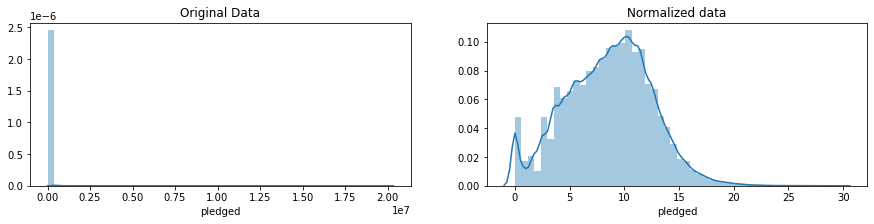

In [74]:
# get only positive pledges (using their indexes)
positive_pledged = kickstarters_2017.pledged.loc[kickstarters_2017.pledged > 0]

# normalize the pledges (w/ Box-Cox)
normalized_pledged = pd.Series(stats.boxcox(positive_pledged)[0], 
                               name='pledged', index=positive_pledged.index)

# plot both together to compare
fig, ax=plt.subplots(1,2,figsize=(15,3))
sns.distplot(positive_pledged, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_pledged, ax=ax[1])
ax[1].set_title("Normalized data")

How does the normalized "usd_pledged_real" column look different from when we normalized the "pledged" column? Or, do they look mostly the same?

The distributions in the normalized data look mostly the same.

## <font color=navy>[3/5] Parsing Dates</font>

In this notebook, we're going to work with dates.

Let's get started!

### Get our environment set up
The first thing we'll need to do is load in the libraries and dataset we'll be using. We'll be working with a dataset that contains information on landslides that occured between 2007 and 2016. In the following exercise, you'll apply your new skills to a dataset of worldwide earthquakes.

In [75]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

# read in our data
landslides = pd.read_csv("catalog.csv")

# set seed for reproducibility
np.random.seed(0)

### Check the data type of our date column  

We begin by taking a look at the first five rows of the data.

In [76]:
landslides.head()

,id,date,time,continent_code,country_name,country_code,state/province,population,city/town,distance,...,geolocation,hazard_type,landslide_type,landslide_size,trigger,storm_name,injuries,fatalities,source_name,source_link
0,34,3/2/07,Night,NaN,United States,US,Virginia,16000,Cherry Hill,3.40765,...,"(38.600900000000003, -77.268199999999993)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,NBC 4 news,http://www.nbc4.com/news/11186871/detail.html
1,42,3/22/07,NaN,NaN,United States,US,Ohio,17288,New Philadelphia,3.33522,...,"(40.517499999999998, -81.430499999999995)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,Canton Rep.com,http://www.cantonrep.com/index.php?ID=345054&C...
2,56,4/6/07,NaN,NaN,United States,US,Pennsylvania,15930,Wilkinsburg,2.91977,...,"(40.4377, -79.915999999999997)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,The Pittsburgh Channel.com,https://web.archive.org/web/20080423132842/htt...
3,59,4/14/07,NaN,NaN,Canada,CA,Quebec,42786,Châteauguay,2.98682,...,"(45.322600000000001, -73.777100000000004)",Landslide,Riverbank collapse,Small,Rain,NaN,NaN,NaN,Le Soleil,http://www.hebdos.net/lsc/edition162007/articl...
4,61,4/15/07,NaN,NaN,United States,US,Kentucky,6903,Pikeville,5.66542,...,"(37.432499999999997, -82.493099999999998)",Landslide,Landslide,Small,Downpour,NaN,NaN,0.0,Matthew Crawford (KGS),NaN


We'll be working with the "date" column from the landslides dataframe. Let's make sure it actually looks like it contains dates.

In [77]:
# print the first few rows of the date column
print(landslides['date'].head())

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object


Yep, those are dates! But just because I, a human, can tell that these are dates doesn't mean that Python knows that they're dates. Notice that at the bottom of the output of head(), you can see that it says that the data type of this column is "object".

> Pandas uses the "object" dtype for storing various types of data types, but most often when you see a column with the dtype "object" it will have strings in it.

If you check the pandas dtype documentation here, you'll notice that there's also a specific datetime64 dtypes. Because the dtype of our column is object rather than datetime64, we can tell that Python doesn't know that this column contains dates.

We can also look at just the dtype of a column without printing the first few rows:

In [78]:
# check the data type of our date column
landslides['date'].dtype

dtype('O')

You may have to check the numpy documentation to match the letter code to the dtype of the object.   
***"O" is the code for "object"***, so we can see that these two methods give us the same information.

### Convert our date columns to datetime

Now that we know that our date column isn't being recognized as a date, it's time to convert it so that it is recognized as a date. This is called "parsing dates" because we're taking in a string and identifying its component parts.

We can pandas what the format of our dates are with a guide called as **"strftime directive"**, which you can find more information on at this [link](https://strftime.org/). The basic idea is that you need to point out which parts of the date are where and what punctuation is between them. There are lots of possible parts of a date, but the most common are %d for day, %m for month, %y for a two-digit year and %Y for a four digit year.

Some examples:

- 1/17/07 has the format "%m/%d/%y"  
- 17-1-2007 has the format "%d-%m-%Y"  

Looking back up at the head of the "date" column in the landslides dataset, we can see that it's in the format "month/day/two-digit year", so we can use the same syntax as the first example to parse in our dates:

In [79]:
# create a new column, date_parsed, with the parsed dates
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

Now when I check the first few rows of the new column, I can see that the dtype is datetime64. I can also see that my dates have been slightly rearranged so that they fit the default order datetime objects (year-month-day).

In [80]:
# print the first few rows
landslides['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

Now that our dates are parsed correctly, we can interact with them in useful ways.

> **What if I run into an error with multiple date formats?** While we're specifying the date format here, sometimes you'll run into an error when there are multiple date formats in a single column. If that happens, you have have pandas try to infer what the right date format should be. You can do that like so:

`landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)`

**Why don't you always use infer_datetime_format = True?**  
There are two big reasons not to always have pandas guess the time format:-  
1. The first is that pandas won't always been able to figure out the correct date format, especially if someone has gotten creative with data entry.  
2. The second is that it's much slower than specifying the exact format of the dates.

### Select the day of the month
Now that we have a column of parsed dates, we can extract information like the day of the month that a landslide occurred.

In [81]:
# get the day of the month from the date_parsed column
day_of_month_landslides = landslides['date_parsed'].dt.day
day_of_month_landslides.head()

0     2.0
1    22.0
2     6.0
3    14.0
4    15.0
Name: date_parsed, dtype: float64

If we tried to get the same information from the original "date" column, we would get an error:   
`AttributeError: Can only use .dt accessor with datetimelike values.`
This is because dt.day doesn't know how to deal with a column with the dtype "object".   
Even though our dataframe has dates in it, we have to parse them before we can interact with them in a useful way.

### Plot the day of the month to check the date parsing
One of the biggest dangers in parsing dates is mixing up the months and days. The to_datetime() function does have very helpful error messages, but it doesn't hurt to double-check that the days of the month we've extracted make sense.

To do this, let's plot a ***histogram of the days of the month***. We expect it to have values between 1 and 31 and, since there's no reason to suppose the landslides are more common on some days of the month than others, a relatively even distribution. (With a dip on 31 because not all months have 31 days.) Let's see if that's the case:

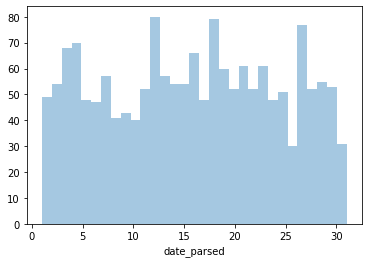

In [82]:
# remove na's
day_of_month_landslides = day_of_month_landslides.dropna()

# plot the day of the month
sns.distplot(day_of_month_landslides, kde=False, bins=31)

plt.show()

Yep, it looks like we did parse our dates correctly & this graph makes good sense to me.

### Exercises (Chapter-3)

### Get our environment set up

The first thing we'll need to do is load in the libraries and dataset we'll be using. We'll be working with a dataset containing information on earthquakes that occured between 1965 and 2016.

In [83]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# read in our data
earthquakes = pd.read_csv("database1.csv")

# set seed for reproducibility
np.random.seed(0)

### 1) Check the data type of our date column
You'll be working with the "Date" column from the earthquakes dataframe. Investigate this column now: does it look like it contains dates? What is the dtype of the column?

In [84]:
earthquakes["Date"].head()

0    01/02/1965
1    01/04/1965
2    01/05/1965
3    01/08/1965
4    01/09/1965
Name: Date, dtype: object

In [12]:
earthquakes["Date"].dtype

dtype('O')

### 2) Convert our date columns to datetime
Most of the entries in the "Date" column follow the same format: "month/day/four-digit year". However, the entry at index 3378 follows a completely different pattern. Run the code cell below to see this.

In [85]:
earthquakes[3378:3383]

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
3379,02/23/1975,03:53:36,-21.727,-71.356,Earthquake,33.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A0A,US,US,US,Reviewed
3380,02/23/1975,07:34:11,-10.879,166.667,Earthquake,33.0,NaN,NaN,5.5,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A0C,US,US,US,Reviewed
3381,02/25/1975,05:20:05,-7.388,149.798,Earthquake,33.0,NaN,NaN,5.5,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A12,US,US,US,Reviewed
3382,02/26/1975,04:48:55,85.047,97.969,Earthquake,33.0,NaN,NaN,5.6,MS,...,NaN,NaN,NaN,NaN,NaN,USP0000A1H,US,US,US,Reviewed


This does appear to be an issue with data entry: ideally, all entries in the column have the same format. We can get an idea of how widespread this issue is by checking the length of each entry in the "Date" column.

In [86]:
date_lengths = earthquakes.Date.str.len()
date_lengths.value_counts()

10    23409
24        3
Name: Date, dtype: int64

Looks like there are two more rows that has a date in a different format. Run the code cell below to obtain the indices corresponding to those rows and print the data.

In [87]:
indices = np.where([date_lengths == 24])[1]
print('Indices with corrupted data:', indices)
earthquakes.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


Given all of this information, it's your turn to create a new column "date_parsed" in the earthquakes dataset that has correctly parsed dates in it.

> **Note**: When completing this problem, you are allowed to (but are not required to) amend the entries in the "Date" and "Time" columns. Do not remove any rows from the dataset.

In [88]:
earthquakes.loc[3378, "Date"] = "02/23/1975"
earthquakes.loc[7512, "Date"] = "04/28/1985"
earthquakes.loc[20650, "Date"] = "03/13/2011"
earthquakes['date_parsed'] = pd.to_datetime(earthquakes['Date'], format = "%m/%d/%Y")

In [89]:
earthquakes["date_parsed"]

0       1965-01-02
1       1965-01-04
2       1965-01-05
3       1965-01-08
4       1965-01-09
           ...    
23407   2016-12-28
23408   2016-12-28
23409   2016-12-28
23410   2016-12-29
23411   2016-12-30
Name: date_parsed, Length: 23412, dtype: datetime64[ns]

### 3) Select the day of the month
Create a Pandas Series day_of_month_earthquakes containing the day of the month from the "date_parsed" column.

In [90]:
# try to get the day of the month from the date column
day_of_month_earthquakes = earthquakes['date_parsed'].dt.day

In [91]:
day_of_month_earthquakes.head()

0    2
1    4
2    5
3    8
4    9
Name: date_parsed, dtype: int64

### 4) Plot the day of the month to check the date parsing
Plot the days of the month from your earthquake dataset.




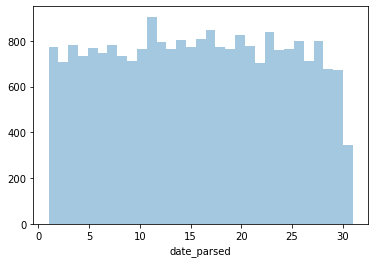

In [92]:
day_of_month_earthquakes = day_of_month_earthquakes.dropna()
sns.distplot(day_of_month_earthquakes, kde=False, bins=31)

## <font color = navy>[4/5] Character Encodings</font>

In this notebook, we're going to be working with different character encodings.

Let's get started!

### Get our environment set up
The first thing we'll need to do is load in the libraries we'll be using. Not our dataset, though: we'll get to it later!

In [93]:
import pandas as pd
import numpy as np

# helpful character encoding module
import chardet

# set seed for reproducibility
np.random.seed(0)

### What are encodings?
Character encodings are specific sets of rules for mapping from raw binary byte strings (that look like this: 0110100001101001) to characters that make up human-readable text (like "hi"). There are many different encodings, and if you tried to read in text with a different encoding than the one it was originally written in, you ended up with scrambled text called "mojibake" (said like mo-gee-bah-kay). Here's an example of mojibake:

æ–‡å—åŒ–ã??

You might also end up with a "unknown" characters. There are what gets printed when there's no mapping between a particular byte and a character in the encoding you're using to read your byte string in and they look like this:

����������

Character encoding mismatches are less common today than they used to be, but it's definitely still a problem. There are lots of different character encodings, but the main one you need to know is UTF-8.

> **UTF-8** is the standard text encoding. All Python code is in UTF-8 and, ideally, all your data should be as well. It's when things aren't in UTF-8 that you run into trouble.

It was pretty hard to deal with encodings in Python 2, but thankfully in Python 3 it's a lot simpler. (Kaggle Notebooks only use Python 3.) There are two main data types you'll encounter when working with text in Python 3. One is is the string, which is what text is by default.

In [94]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

The other data is the bytes data type, which is a sequence of integers. You can convert a string into bytes by specifying which encoding it's in:

In [95]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors="replace")

# check the type
type(after)

bytes

If you look at a bytes object, you'll see that it has a b in front of it, and then maybe some text after. That's because bytes are printed out as if they were characters encoded in ASCII. (ASCII is an older character encoding that doesn't really work for writing any language other than English.)   
Here you can see that our euro symbol has been replaced with some mojibake that looks like "\xe2\x82\xac" when it's printed as if it were an ASCII string.

In [96]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

When we convert our bytes back to a string with the correct encoding, we can see that our text is all there correctly, which is great! :)

In [97]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


However, when we try to use a different encoding to map our bytes into a string, we get an error. This is because the encoding we're trying to use doesn't know what to do with the bytes we're trying to pass it. You need to tell Python the encoding that the byte string is actually supposed to be in.

> You can think of different encodings as different ways of recording music. You can record the same music on a CD, cassette tape or 8-track. While the music may sound more-or-less the same, you need to use the right equipment to play the music from each recording format. The correct decoder is like a cassette player or a CD player. If you try to play a cassette in a CD player, it just won't work.

In [98]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 25: ordinal not in range(128)

We can also run into trouble if we try to use the wrong encoding to map from a string to bytes. Like I said earlier, strings are UTF-8 by default in Python 3, so if we try to treat them like they were in another encoding we'll create problems.

For example, if we try to convert a string to bytes for ASCII using `encode()`, we can ask for the bytes to be what they would be if the text was in ASCII. Since our text isn't in ASCII, though, there will be some characters it can't handle. We can automatically replace the characters that ASCII can't handle. If we do that, however, any characters not in ASCII will just be replaced with the unknown character. Then, when we convert the bytes back to a string, the character will be replaced with the unknown character. The dangerous part about this is that there's not way to tell which character it should have been. That means we may have just made our data unusable!

In [99]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

This is the euro symbol: ?


This is bad and we want to avoid doing it!   
It's far better to convert all our text to UTF-8 as soon as we can and keep it in that encoding.  
The best time to convert non UTF-8 input into UTF-8 is when you read in files, which we'll talk about next.

### Reading in files with encoding problems
Most files you'll encounter will probably be encoded with UTF-8. This is what Python expects by default, so most of the time you won't run into problems. However, sometimes you'll get an error like this:

In [100]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 11: invalid start byte

Notice that we get the same `UnicodeDecodeError` we got when we tried to decode UTF-8 bytes as if they were ASCII! This tells us that this file isn't actually UTF-8. We don't know what encoding it actually is though. One way to figure it out is to try and test a bunch of different character encodings and see if any of them work.   
A better way, though, is to use the **chardet** module to try and automatically guess what the right encoding is. It's not 100% guaranteed to be right, but it's usually faster than just trying to guess.

I'm going to just look at the first ten thousand bytes of this file. This is usually enough for a good guess about what the encoding is and is much faster than trying to look at the whole file. (Especially with a large file this can be very slow.) Another reason to just look at the first part of the file is that we can see by looking at the error message that the first problem is the 11th character. So we probably only need to look at the first little bit of the file to figure out what's going on.

In [101]:
# look at the first ten thousand bytes to guess the character encoding
with open("ks-projects-201801.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


So chardet is 73% confidence that the right encoding is "Windows-1252". Let's see if that's correct:

In [102]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


Yep, looks like chardet was right! The file reads in with no problem (although we do get a warning about datatypes) and when we look at the first few rows it seems to be fine.

> **What if the encoding chardet guesses isn't right?** Since chardet is basically just a fancy guesser, sometimes it will guess the wrong encoding. One thing you can try is looking at more or less of the file and seeing if you get a different result and then try that.

### Saving your files with UTF-8 encoding
Finally, once you've gone through all the trouble of getting your file into UTF-8, you'll probably want to keep it that way.  
The easiest way to do that is to save your files with UTF-8 encoding.  
The good news is, since UTF-8 is the standard encoding in Python, when you save a file it will be saved as UTF-8 by default:

In [103]:
# save our file (will be saved as UTF-8 by default!)
kickstarter_2016.to_csv("ks-projects-201801-utf8.csv")

### Exercises (Chapter-4)

### Get our environment set up
The first thing we'll need to do is load in the libraries we'll be using.

In [104]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful character encoding module
import chardet

# set seed for reproducibility
np.random.seed(0)

### 1) What are encodings?
You're working with a dataset composed of bytes. Run the code cell below to print a sample entry.

In [105]:
sample_entry = b'\xa7A\xa6n'
print(sample_entry)
print('data type:', type(sample_entry))

b'\xa7A\xa6n'
data type: <class 'bytes'>


You notice that it doesn't use the standard UTF-8 encoding.

Use the next code cell to create a variable `new_entry` that changes the encoding from "`big5-tw`" to "`utf-8`". new_entry should have the bytes datatype.

In [107]:
before = sample_entry.decode("big5_tw")
new_entry = before.encode()
new_entry

b'\xe4\xbd\xa0\xe5\xa5\xbd'

### 2) Reading in files with encoding problems
Use the code cell below to read in this file at path "`../input/fatal-police-shootings-in-the-us/PoliceKillingsUS.csv`".

Figure out what the correct encoding should be and read in the file to a DataFrame `police_killings`.

In [108]:
with open("PoliceKillingsUS.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [109]:
police_killings = pd.read_csv("PoliceKillingsUS.csv", encoding = 'Windows-1252')
police_killings.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


### 3) Saving your files with UTF-8 encoding
Save a version of the police killings dataset to CSV with UTF-8 encoding. Your answer will be marked correct after saving this file.

Note: When using the `to_csv()` method, supply only the name of the file (e.g., "`my_file.csv`"). This saves the file at the filepath "`/kaggle/working/my_file.csv`".

In [110]:
police_killings.to_csv('PoliceKillingsUS.csv')

## <font color = navy>[5/5] Inconsistent Data Entry</font>

In this notebook, we're going to learn how to clean up inconsistent text entries.

Let's get started!

### Get our environment set up
The first thing we'll need to do is load in the libraries and dataset we'll be using.

In [111]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

# read in all our data
professors = pd.read_csv("pakistan_intellectual_capital.csv")

# set seed for reproducibility
np.random.seed(0)

#### Do some preliminary text pre-processing
We'll begin by taking a quick look at the first few rows of the data.

In [113]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Say we're interested in cleaning up the "Country" column to make sure there's no data entry inconsistencies in it. We could go through and check each row by hand, of course, and hand-correct inconsistencies when we find them. There's a more efficient way to do this, though!

In [114]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

Just looking at this, I can see some problems due to inconsistent data entry: ' Germany', and 'germany', for example, or ' New Zealand' and 'New Zealand'.

The first thing I'm going to do is make everything lower case (I can change it back at the end if I like) and remove any white spaces at the beginning and end of cells. Inconsistencies in capitalizations and trailing white spaces are very common in text data and you can fix a good 80% of your text data entry inconsistencies by doing this.

In [24]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

Next we're going to tackle more difficult inconsistencies.

### Use fuzzy matching to correct inconsistent data entry
Alright, let's take another look at the 'Country' column and see if there's any more data cleaning we need to do.

In [25]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea',
       'southkorea', 'spain', 'sweden', 'thailand', 'turkey', 'uk',
       'urbana', 'usa', 'usofa'], dtype=object)

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same.

We're going to use the [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) package to help identify which strings are closest to each other. This dataset is small enough that we could probably could correct errors by hand, but that approach doesn't scale well. (Would you want to correct a thousand errors by hand? What about ten thousand? Automating things as early as possible is generally a good idea. Plus, it’s fun!)

> **Fuzzy matching**: The process of automatically finding text strings that are very similar to the target string. In general, a string is considered "closer" to another one the fewer characters you'd need to change if you were transforming one string into another. So "apple" and "snapple" are two changes away from each other (add "s" and "n") while "in" and "on" and one change away (rplace "i" with "o"). You won't always be able to rely on fuzzy matching 100%, but it will usually end up saving you at least a little time.

Fuzzywuzzy returns a ratio given two strings. The closer the ratio is to 100, the smaller the edit distance between the two strings. Here, we're going to get the ten strings from our list of cities that have the closest distance to "d.i khan".

In [26]:
# get the top 10 closest matches to "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# take a look at them
matches

[('south korea', 100),
 ('southkorea', 48),
 ('saudi arabia', 43),
 ('norway', 35),
 ('ireland', 33),
 ('portugal', 32),
 ('singapore', 30),
 ('netherland', 29),
 ('macau', 25),
 ('usofa', 25)]

We can see that two of the items in the cities are very close to "south korea": "south korea" and "southkorea". Let's replace all rows in our "Country" column that have a ratio of > 47 with "south korea".

To do this, I'm going to write a function. (It's a good idea to write a general purpose function you can reuse if you think you might have to do a specific task more than once or twice. This keeps you from having to copy and paste code too often, which saves time and can help prevent mistakes.)

In [27]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")

Now that we have a function, we can put it to the test!

In [28]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"

replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

All done!


And now let's check the unique values in our "Country" column again and make sure we've tidied up "south korea" correctly.

In [29]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Excellent! Now we only have "south korea" in our dataframe and we didn't have to change anything by hand.

### Exercises (Chapter-5)

### Get our environment set up
The first thing we'll need to do is load in the libraries and dataset we'll be using. We use the same dataset from the tutorial.

In [115]:
# modules we'll use
import pandas as pd
import numpy as np

# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

# set seed for reproducibility
np.random.seed(0)

### 1) Examine another column
Write code below to take a look at all the unique values in the "Graduated from" column.

In [32]:
professors['Graduated from'].unique()

array(['Asian Institute of Technology',
       'Balochistan University of Information Technology, Engineering and Management Sciences',
       'University of Balochistan',
       "Sardar Bahadur Khan Women's University",
       'SRH Hochschule Heidelberg',
       'Institute of Business Administration,Karachi', 'DUET,Karachi',
       'University of Turbat', 'University of Vienna',
       'Monash University', 'University of Stirling',
       'Chinese Academy of Sciences', 'University of Innsbruck',
       'Vienna University of Technology', 'University of Paris-Est',
       'The University of Cambridge', 'Harbin Institute of Technology',
       'University of Nice, Sophia Antipolis', 'The University of York',
       'Galilée - Université Paris 13', 'University of Bedfordshire',
       'North Dakota State University', 'Kyungpook National University',
       'The University of Manchester',
       'National University of Sciences and Technology',
       'FAST– National University of Computer

Do you notice any inconsistencies in the data?   
Can any of the inconsistencies in the data be fixed by removing white spaces at the beginning and end of cells?

There are inconsistencies that can be fixed by removing white spaces at the beginning and end of cells. For instance, "University of Central Florida" and " University of Central Florida" both appear in the column.

### 2) Do some text pre-processing
Convert every entry in the "Graduated from" column in the professors DataFrame to remove white spaces at the beginning and end of cells.

In [33]:
professors['Graduated from'] = professors['Graduated from'].str.strip()

### 3) Continue working with countries
In the tutorial, we focused on cleaning up inconsistencies in the "Country" column. Run the code cell below to view the list of unique values that we ended with.

In [34]:
# get all the unique values in the 'City' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Take another look at the "Country" column and see if there's any more data cleaning we need to do.

It looks like 'usa' and 'usofa' should be the same country. Correct the "Country" column in the dataframe so that 'usofa' appears instead as 'usa'.

Use the most recent version of the DataFrame (with the whitespaces at the beginning and end of cells removed) from question 2.

In [35]:
matches = fuzzywuzzy.process.extract("usa", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
replace_matches_in_column(df=professors, column='Country', string_to_match="usa", min_ratio=70)

All done!


In [39]:
print(professors['Country'].unique().sort())

None


### Congratulations!

Congratulations for completing the Data Cleaning course on Kaggle Learn!